# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
CACHE_DIR = "/scratch/chaijy_root/chaijy0/sstorks/.cache/"

1.13.0+cu117


# CaptainCook4D

## Data loading

In [1]:
VIDEO_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv" # Directory containing CaptainCook4D mp4s
ANNOTATIONS_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/annotations"

Boilerplate code to load video frames from video files (from GPT4):

In [2]:
import cv2
import numpy as np

def get_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Cannot open video file")
    
    return cap
    # remember to call cap.release() later

def extract_frames(cap, times):
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frames = []

    for t in times:
        frame_number = int(t * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Convert to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frames.append(frame)
        else:
            print(f"Warning: Frame at time {t} seconds could not be read.")
            frames.append(None)

    return frames

Other utils functions:

In [3]:
def generate_float_series(start, end, step):
    # Ensure step is a positive float
    step = abs(step)

    # Initialize the series with the start value
    series = [start]

    # Generate numbers in the series
    while start + step <= end:
        start += step
        series.append(start)

    # Check if the end value is already in the series
    if series[-1] != end:
        series.append(end)

    return series

Sample video: /nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv/29_7_360p.mp4
Recipe name: Caprese Bruschetta


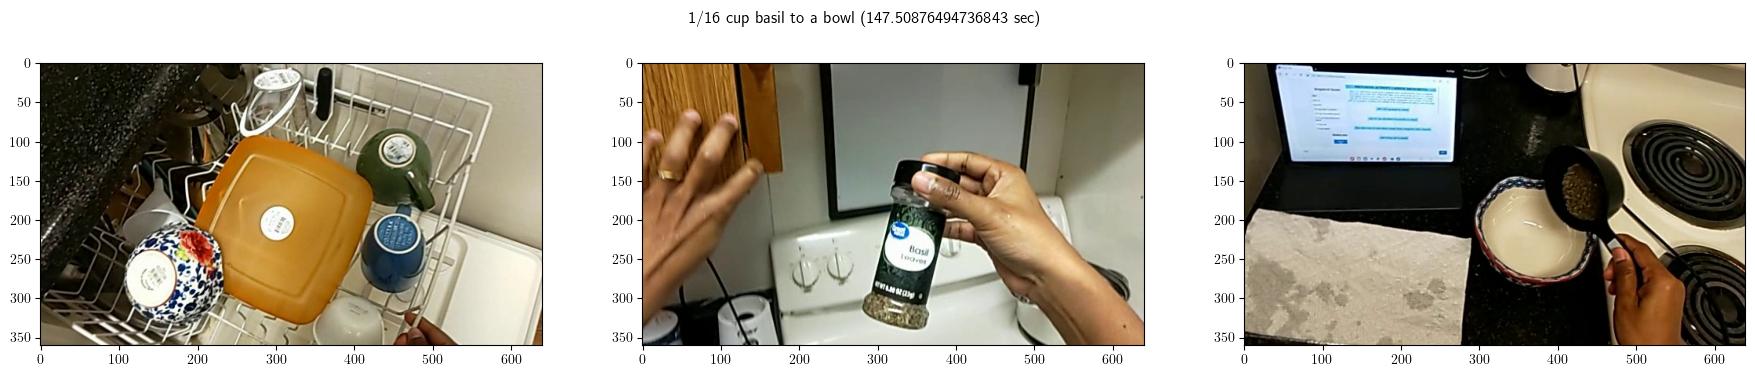

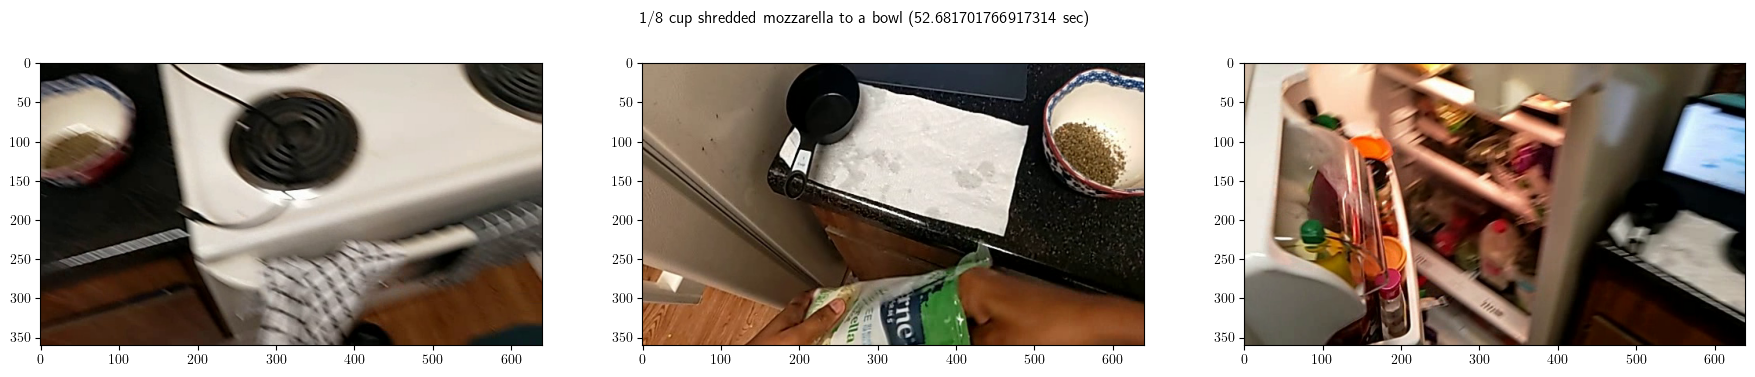

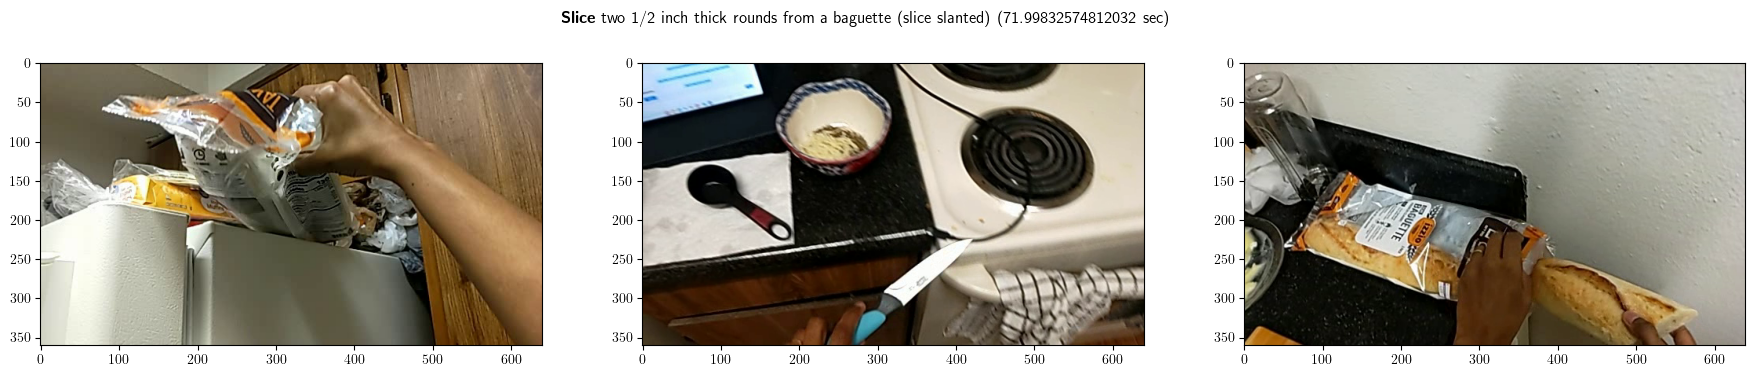

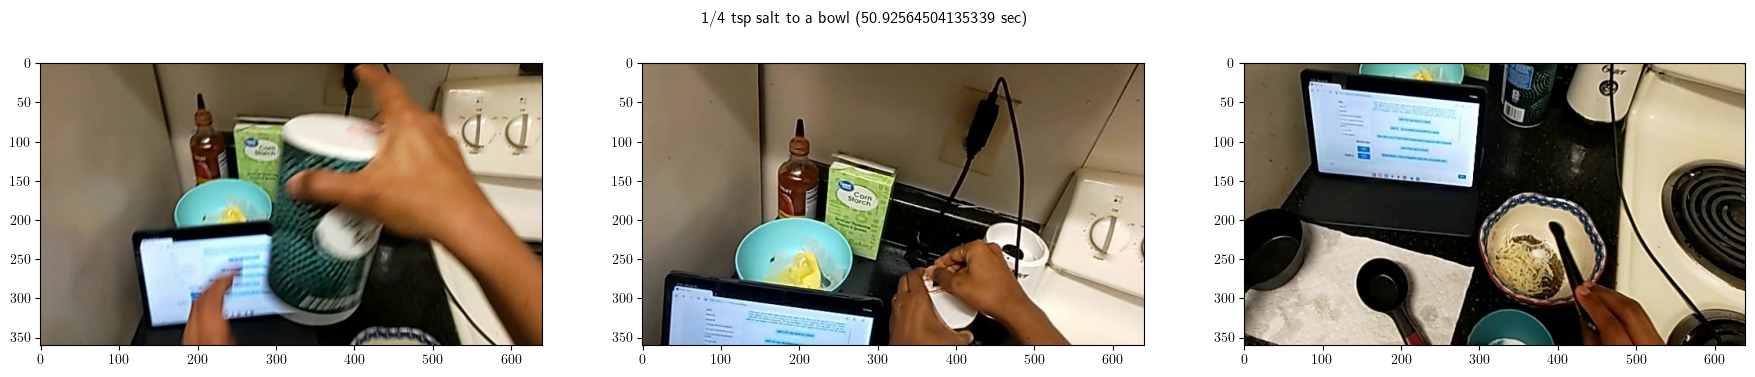

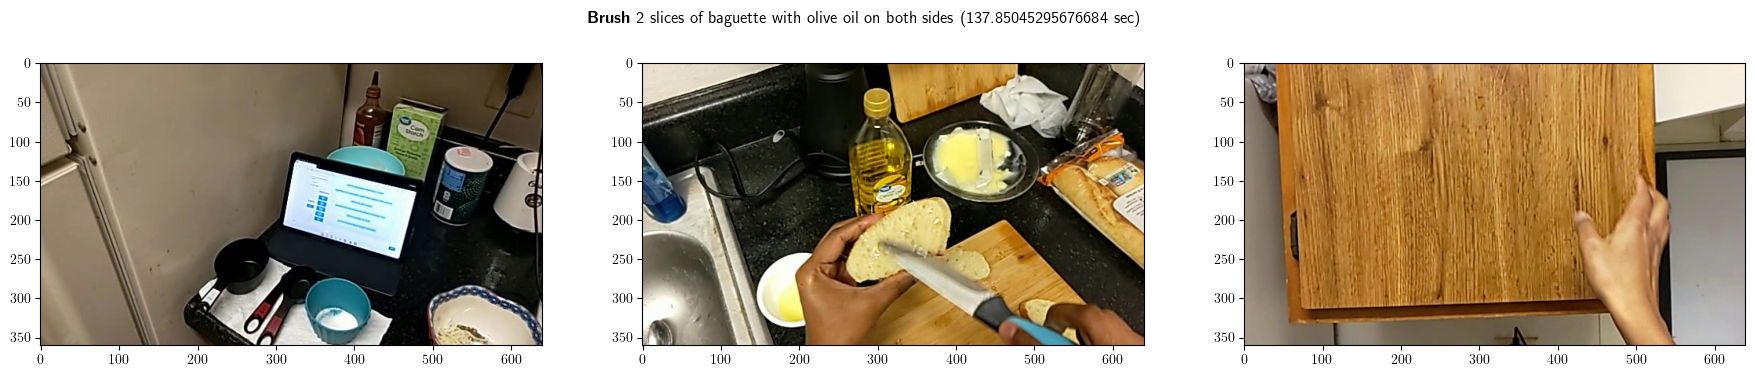

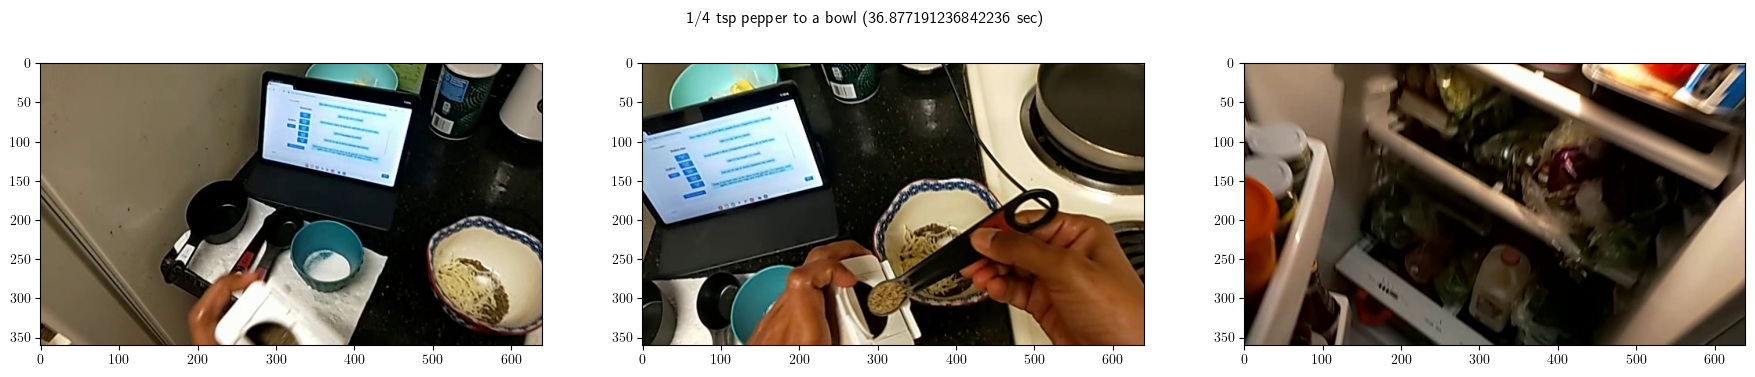

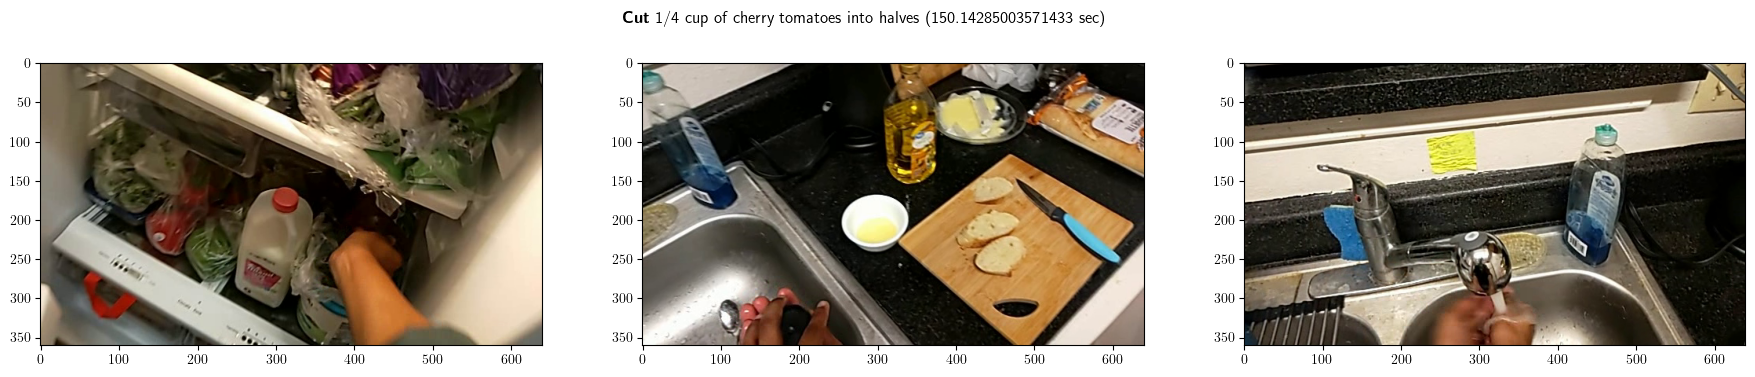

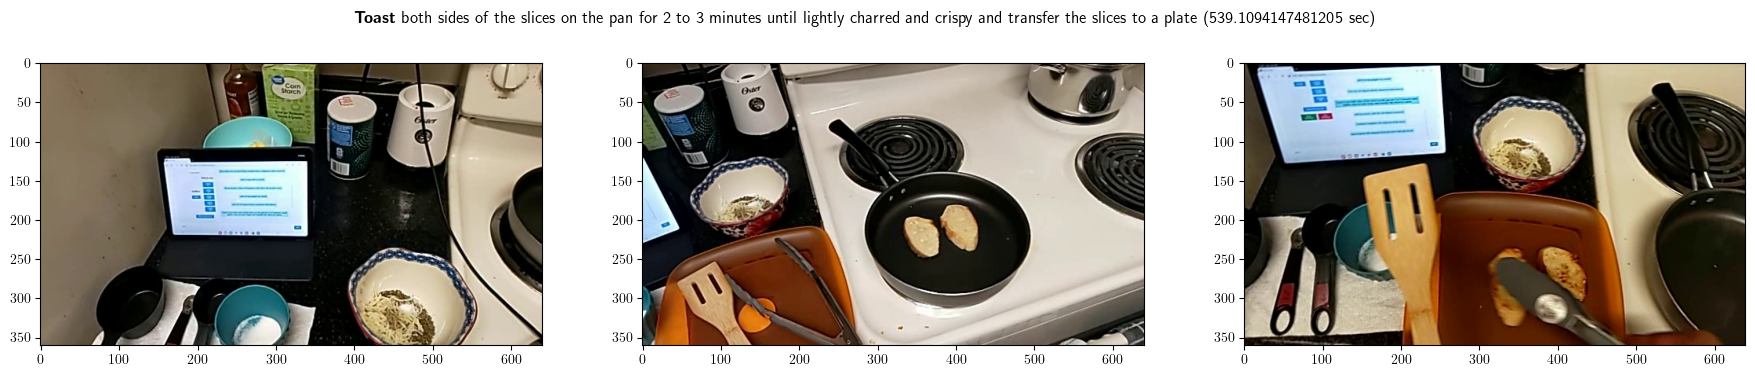

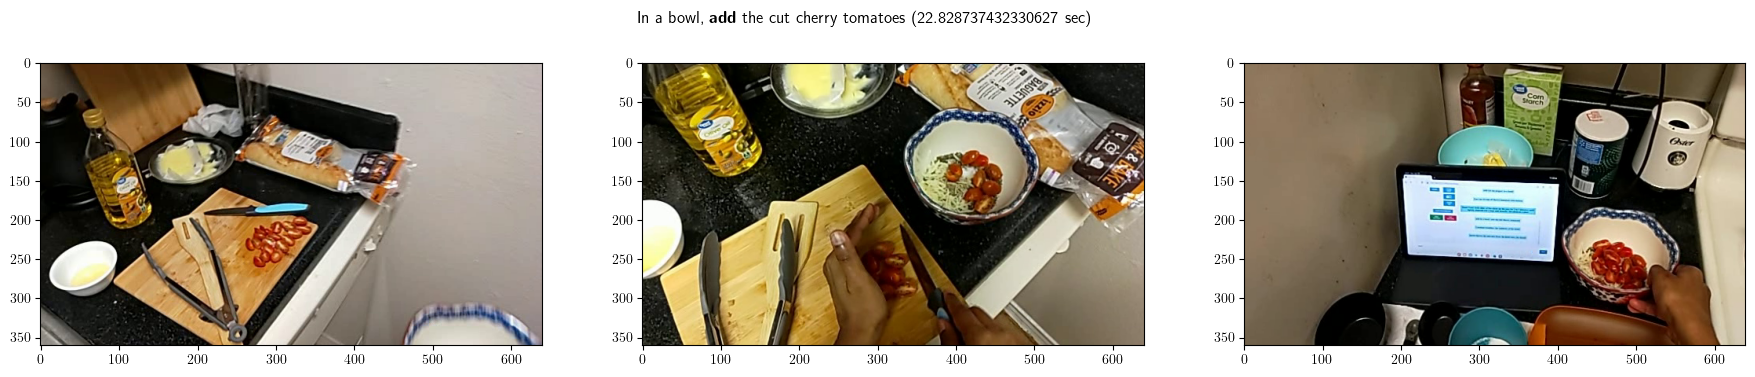

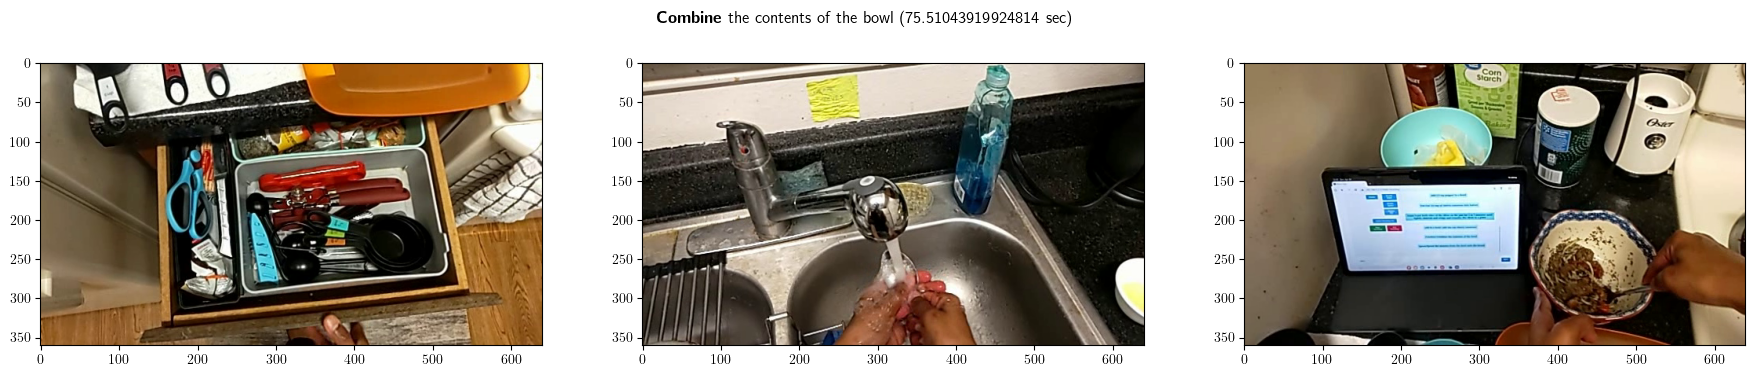

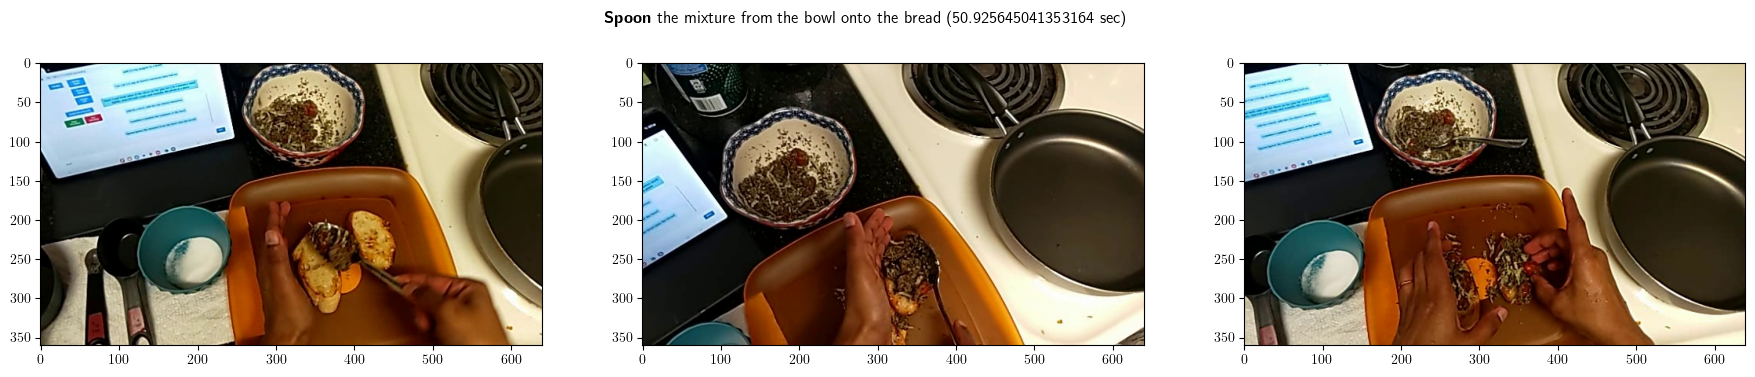

In [10]:
import os, json
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# Pick a sample video from CaptainCook4D
all_video_files = os.listdir(VIDEO_DIR)
sample_video_path = [f for f in all_video_files if f.endswith('.mp4')][3]
sample_video_id = "_".join(sample_video_path.split('_')[:2])
sample_video_path = os.path.join(VIDEO_DIR, sample_video_path)
print("Sample video:", sample_video_path)
sample_video = get_video(sample_video_path)

step_annotations = json.load(open(os.path.join(ANNOTATIONS_DIR, "annotation_json/complete_step_annotations.json"), "r"))
print("Recipe name:", step_annotations[sample_video_id]["activity_name"])

all_frames = []

# Load step annotations for it and display precondition/effect frames
for step in step_annotations[sample_video_id]["steps"]:
    # Extract some keyframes for the action
    pnr = (step['start_time'] + step['end_time']) / 2.0 # take "point of no return" as midpoint of action
    step_duration = step['end_time'] - step['start_time']

    # Some steps are skipped
    if step_duration < 0.1:
        continue

    # TODO: this method of adjusting the start and end times still doesn't account for noise in labels. Maybe we can use segment anything or GLIP to smooth this a bit later.
    # ^ however, we might just end up running a model on several frames, e.g., 1s apart, so this may not matter - just for illustration purpose for now
    adjusted_start = step['start_time'] + min(step_duration * 0.05, 0.5) # Adjust the start time to be later by a maximum of 3 seconds
    adjusted_end = step['end_time'] - min(step_duration * 0.3, 3) # Adjust the end time to be earlier by a maximum of 3 seconds

    times = [adjusted_start, pnr, adjusted_end]
    # times = generate_float_series(adjusted_start, adjusted_end, 1.0) # ultimately, we'll want to look at every image frame in some regular interval to determine if there's a mistake
    frames = extract_frames(sample_video, times) 

    fig, axarr = plt.subplots(1, len(times), figsize=(22, 4))

    verb, action_description = step['description'].split("-")[0], "-".join(step['description'].split("-")[1:])
    stylized_title = action_description.replace(verb, r'\textbf{' + verb + '}')

    fig.suptitle(f"{stylized_title} ({step_duration} sec)")
    for frame, ax in zip(frames, axarr):
        if frame is not None:
            ax.imshow(frame)
    plt.show()
    
    all_frames.append(frames)

sample_video.release()

## Model demo

Load model:

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)


1.13.0+cu117
11.7


In [4]:
from transformers import AutoProcessor, AutoModelForVision2Seq

MODEL_NAME = "microsoft/kosmos-2-patch14-224"

model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
model.cuda()

print(model.device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

[2024-01-18 09:58:32,560] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cuda:0


Utility functions for Kosmos-2:

In [ ]:
from PIL import Image
import torch
import os
import numpy as np
import cv2
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt

IMAGES_PATH = "/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/state_example_images/"

def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)

def draw_entity_boxes_on_image(image, entities, show=False, save_path=None):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    elif isinstance(image, str):
        if os.path.exists(image):
            pil_img = Image.open(image).convert("RGB")
            image = np.array(pil_img)[:, :, [2, 1, 0]]
            image_h = pil_img.height
            image_w = pil_img.width
        else:
            raise ValueError(f"invaild image path, {image}")
    elif isinstance(image, torch.Tensor):
        # pdb.set_trace()
        image_tensor = image.cpu()
        reverse_norm_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        reverse_norm_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])[:, None, None]
        image_tensor = image_tensor * reverse_norm_std + reverse_norm_mean
        pil_img = T.ToPILImage()(image_tensor)
        image_h = pil_img.height
        image_w = pil_img.width
        image = np.array(pil_img)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, (start, end), bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])
    if save_path:
        pil_image.save(save_path)
    if show:
        plt.imshow(pil_image)
        plt.show()
    return new_image


Zero-shot prompt:

In [ ]:
with torch.no_grad():
    
    input_img = frames[8][1]
    
    prompt = "<grounding> An image of"
    
    inputs = processor(text=prompt, images=input_img, return_tensors="pt")

    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"][:, :-1],
        attention_mask=inputs["attention_mask"][:, :-1],
        img_features=None, # NOTE: we can input image features directly?
        img_attn_mask=inputs["img_attn_mask"][:, :-1],
        use_cache=True,
        max_new_tokens=30,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
    # processed_text = "<grounding> An image of<phrase> an orange</phrase><object><patch_index_0256><patch_index_0817></object> and<phrase> a peeled orange</phrase><object><patch_index_0208><patch_index_0831></object>"
    processed_text, entities = processor.post_process_generation(processed_text)

    print(processed_text)
    # # plt.imshow(input_img)
    # plt.show()
    draw_entity_boxes_on_image(input_img, entities, show=True)

# EPIC KITCHENS

In [ ]:
import pandas as pd

# PARTITION = "validation"
PARTITION = "train"
EK_ANNOTATION_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/annotations/EPIC_100_{PARTITION}_full_sent.csv"
annotations = pd.read_csv(EK_ANNOTATION_PATH)
EK_55_VIDEO_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/55"
EK_100_VIDEO_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/100"


# # Load visual annotations
# NOUN_CLASSES_PATH = "/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS-VISOR/2v6cgv1x04ol22qp9rm9x2j6a7/EPIC_100_noun_classes_v2.csv"
# EK_VISUAL_ANNOTATION_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS-VISOR/2v6cgv1x04ol22qp9rm9x2j6a7/GroundTruth-SparseAnnotations/annotations/{PARTITION}"

## 1 recipe, 2 video clips formulation

Collect lists of clips for all videos in EPIC KITCHENS:

In [ ]:
from pprint import pprint
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
import json
import os
import numpy as np

structured_action_lists = defaultdict(dict)

for row_idx, row in tqdm(annotations.iterrows(), total=len(annotations)):
    
    participant_index, video_index, clip_index = row['narration_id'].split('_')
    video_index = participant_index + "_" + str(video_index)
    clip_index = int(clip_index)

    narration_text = row['full_sent_narration']
    
    start_timestamp = row['start_timestamp']
    start_timestamp = datetime.strptime(start_timestamp, "%H:%M:%S.%f")
    stop_timestamp = row['stop_timestamp']
    stop_timestamp = datetime.strptime(stop_timestamp, "%H:%M:%S.%f")
    action_seconds = stop_timestamp - start_timestamp
    action_seconds = action_seconds.total_seconds()
    
    verb = row['verb']
    noun = row['noun'] # TODO: "all_nouns" key gives access to other noun participants where applicable

    structured_action_lists[video_index][clip_index] = {
        "video_id": video_index,
        "clip_index": clip_index,
        "verb": verb,
        "noun": noun,
        "all_nouns": eval(row["all_nouns"]),
        "narration_text": narration_text,
        "action_seconds": action_seconds,
        "start_timestamp": row['start_timestamp'],
        "stop_timestamp": row['stop_timestamp'],
    }
    
print(f"{len(structured_action_lists)} videos collected from EPIC KITCHENS")

# smooth out to a dict of lists
for video_id in structured_action_lists:
    min_clip_id = min(list(structured_action_lists[video_id].keys()))
    max_clip_id = max(list(structured_action_lists[video_id].keys()))
    
    new_list = []
    last_action = None
    for clip_id in range(min_clip_id, max_clip_id+1):
        
        if clip_id not in structured_action_lists[video_id]:
            continue
        
        current_action = structured_action_lists[video_id][clip_id]
        new_list.append(current_action)
        
    structured_action_lists[video_id] = new_list

Retrieve clips for TRAVEl examples:

In [ ]:
from pprint import pprint

query_verb = "roll"
query_nouns = {"tortilla",}

retrieved_clips = []
for video in structured_action_lists:
    for clip in structured_action_lists[video]:
        if clip['verb'] == query_verb and set(clip['all_nouns']) == set(query_nouns):
            retrieved_clips.append(clip)

print(f"{len(retrieved_clips)} clips retrieved from {PARTITION} partition of EK-100")
videos_to_look_at = list(set([clip['video_id'] for clip in retrieved_clips]))
print("In videos:", videos_to_look_at)

for clip in retrieved_clips:
    pprint(
        {
            "video_id": clip['video_id'],
            # "clip_index": clip['clip_index'],
            # "verb": clip['verb'],
            # "all_nouns": clip['all_nouns'],
            "start_timestamp": clip['start_timestamp'],
            "stop_timestamp": clip['stop_timestamp'],            
        }
    )

Retrieve videos for clips:

In [ ]:
import torch
from video_blip.data.epic_kitchens import EpicKitchensDataset

dataset = EpicKitchensDataset(EK_ANNOTATION_PATH,
                              EK_55_VIDEO_PATH,
                              EK_100_VIDEO_PATH,
                              )

In [ ]:
for item in dataset:
    pprint(item)
    break